# Figure 2

**Figure 2.** Profiles of domain-averaged cloud hydrometeor contents and total cloud fraction, decomposed into the contributions from liquid, ice, and mixed-phase clouds for all four LEM domains. Thin lines show profiles for nine snapshots between hours 10 to 14. The thick lines show time-averaged profiles. The threshold used to determine cloudy boxes for both ice and liquid water contents is 10$^{-8}$ \unit{kg} \unit{kg}$^{-1}$ \citep{Costa20}. Note the different y-axes for panels (a) and (b).

---
@ Behrooz Keshtgar, KIT 2023

## 1- load python packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import matplotlib as mpl
import colorlegend
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.colors as mcolors
from matplotlib import cm
import warnings
warnings.filterwarnings("ignore")

For reference, print package versions to screen:

In [2]:
print('xarrary:   ', xr.__version__)
print('numpy:     ', np.__version__)
import matplotlib; print('matplotlib:', matplotlib.__version__); del matplotlib

xarrary:    0.16.0
numpy:      1.23.5
matplotlib: 3.3.0


**Since datasets are large, I use DASK to speed up my analysis**

In [3]:
import dask
from dask.distributed import Client, progress, wait
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
client = Client()
client

<Client: 'tcp://127.0.0.1:37461' processes=16 threads=256, memory=252.72 GB>

## 2- Loading datasets 

In [4]:
# Dictionary for loading simulations
simdict = {
         'LC1-LES-471x667km-lon25-lat40-300m-0006' : {'res':'300', 'radiation':4, 'mphy':0.8}, # Only cloud radiation, dom 01
         'LC1-LES-471x667km-lon40-lat44-300m-0003' : {'res':'300', 'radiation':4, 'mphy':0.8}, # Only cloud radiation, dom 02
         'LC1-LES-471x667km-lon30-lat53-300m-0005' : {'res':'300', 'radiation':4, 'mphy':0.8}, # Only cloud radiation, dom 03
         'LC1-LES-471x667km-lon50-lat48-300m-0004' : {'res':'300', 'radiation':4, 'mphy':0.8}, # Only cloud radiation, dom 04
          }

In [5]:
#adjusting time steps
rng = pd.date_range('2022-01-05-06', periods=25, freq="30 min")
df = pd.DataFrame({ 'Date': rng })
t =  df.values[:,0]

def load_simulations():
    ds_list = []
    for sim in list(simdict.keys()): 
        
        print('Working on loading data for', sim)
        path = '/work/bb1135/icon_output/'+sim+'/'
        
        fname1  = path+"icon-cld3d*.nc"
        ds_var1 = xr.open_mfdataset(fname1,combine='by_coords',chunks={'time': 1, 'height': 3},parallel=True)[['tot_qc_dia','tot_qi_dia','clc','reff_qc_ecrad','reff_qi_ecrad']]
        # total cloud condensate
        ds_var1['tot_q_dia'] = ds_var1['tot_qc_dia'] + ds_var1['tot_qi_dia']
        
        fname2  = path+"icon-atm3d*.nc"
        ds_var2 = xr.open_mfdataset(fname2,combine='by_coords',chunks={'time': 1, 'height': 3},parallel=True)[['rho','z_ifc']]
            
        grid = xr.open_dataset(path+'grid_DOM01.nc')[['clon','clat','vlon','vlat','vertex_of_cell']].rename({'cell': 'ncells'}) 
        
        ds = xr.merge([ds_var1,ds_var2,grid])
        ds['clon'] = (np.rad2deg(ds['clon']))
        ds['clat'] = (np.rad2deg(ds['clat']))
        ds['vlon'] = (np.rad2deg(ds['vlon']))
        ds['vlat'] = (np.rad2deg(ds['vlat']))
        
        ds.coords['time'] = t
        ds_list.append(ds)

    return ds_list
#----------------------------------
ds_list = load_simulations()
#----------------------------------
## I need height values at full-levels
z_ifc = xr.open_dataset('/work/bb1135/icon_output/LC1-LES-471x667km-lon40-lat44-300m-0003/icon-atm3d_ML_20220105T120033Z.nc')["z_ifc"].isel(ncells=20000)
zfull  = ((z_ifc - z_ifc.diff('height_3')/2).values)*1e-3 # km

Working on loading data for LC1-LES-471x667km-lon25-lat40-300m-0006
Working on loading data for LC1-LES-471x667km-lon40-lat44-300m-0003
Working on loading data for LC1-LES-471x667km-lon30-lat53-300m-0005
Working on loading data for LC1-LES-471x667km-lon50-lat48-300m-0004


## 3- Average profiles of cloud hydrometeor contents and total cloud fraction

In [6]:
# deriving required variables
d_list = []
for i in range(len(ds_list)):
    print('working on ds_list:',i)
    # selecting time steps, we also need to get rid of the LTBC boundaries
    ds = ds_list[i].sel(time=slice('2022-01-05T10:00:00.000000000','2022-01-05T14:00:00.000000000')).isel(ncells=slice(55000,3489474))

    # liquid water/ ice content
    ds['LWC'] = (1000*(ds['tot_qc_dia'] * ds['rho'])) # g/m3
    ds['IWC'] = (1000*(ds['tot_qi_dia'] * ds['rho'])) # g/m3
    ds['CLD'] = (1000*(ds['tot_q_dia'] * ds['rho'])) # g/m3

    # applying the threshold
    thres = 1e-8 # kg/kg
    LWC_mean = ds['LWC'].where(ds['tot_qc_dia'] > thres).fillna(0.0).mean(dim=['ncells']).compute()
    IWC_mean = ds['IWC'].where(ds['tot_qi_dia'] > thres).fillna(0.0).mean(dim=['ncells']).compute()
  
    # cloud fraction 
    # empty data arrays
    clci = np.zeros((ds.time.size,ds.height.size))
    clcw = np.zeros((ds.time.size,ds.height.size))
    clcm = np.zeros((ds.time.size,ds.height.size))
    clct = np.zeros((ds.time.size,ds.height.size))
    # loop over time
    
    print('calculating cloud fractions')
    thres = 1e-8 # kg/kg
    print('calculating cloud fractions')
    clct = ds['tot_q_dia'].where(ds['tot_q_dia'] > thres).count(dim=['ncells']).values/len(ds.ncells)
    # mixed-phase cloud fraction
    clcm = ds['tot_q_dia'].where((ds['tot_qc_dia'] > thres)&(ds['tot_qi_dia'] > thres)).count(dim=['ncells']).values/len(ds.ncells)
    # pure ice cloud fraction
    clci = ds['tot_q_dia'].where((ds['tot_qi_dia'] > thres)&(ds['tot_qc_dia'] < thres)).count(dim=['ncells']).values/len(ds.ncells)
    # pure water cloud fraction
    clcw = ds['tot_q_dia'].where((ds['tot_qc_dia'] > thres)&(ds['tot_qi_dia'] < thres)).count(dim=['ncells']).values/len(ds.ncells)
    
    print('calculation of average and std of cloud fractions')
    
    list_var = [LWC_mean,IWC_mean,clci,clcw,clcm,clct]
    d_list.append(list_var)
    
    del LWC_mean,IWC_mean,clci,clcw,clcm,clct,ds

working on ds_list: 0
calculating cloud fractions
calculating cloud fractions
calculation of average and std of cloud fractions
working on ds_list: 1
calculating cloud fractions
calculating cloud fractions
calculation of average and std of cloud fractions
working on ds_list: 2
calculating cloud fractions
calculating cloud fractions
calculation of average and std of cloud fractions
working on ds_list: 3
calculating cloud fractions
calculating cloud fractions
calculation of average and std of cloud fractions


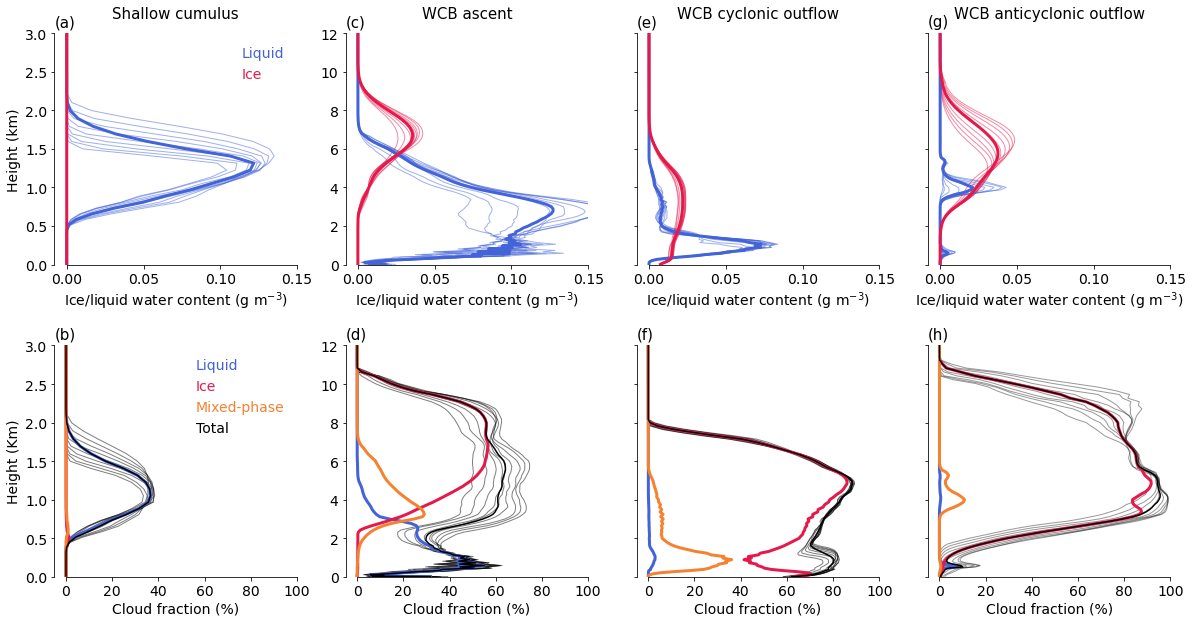

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

i = 0

for ax in axes.flat:
    
    ax.tick_params(labelsize=14)
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    
    if i in [4,5,6,7]:
    
        ax.spines['bottom'].set_bounds(0,100)
        ax.set_xticks(np.arange(0,120,20))
        ax.set_xlim([-5,100])
        
    if i in [0,1,2,3]:    
        ax.spines['bottom'].set_bounds(0,1.5*1e-1)
        ax.set_xticks(np.arange(0,2,0.5)*1e-1)
        ax.set_xlim([-0.08*1e-1,1.5*1e-1])
        
    #--------------------------------------------------------------------------------------    
    if i == 0:

        for t in range(9):
            ax.plot(d_list[0][0][t],zfull,color='#4363d8',lw=1,alpha=0.5)
            ax.plot(d_list[0][1][t],zfull,color='#e6194B',lw=1,alpha=0.5)

        ax.plot(d_list[0][0].mean('time'),zfull,color='#4363d8',label='Liquid',lw=3)
        ax.plot(d_list[0][1].mean('time'),zfull,color='#e6194B',label='Ice',lw=3)
        
        lg=colorlegend.color_legend(ax,loc=1,fsize=14)
        ax.set_ylabel('Height (km)', fontsize=14)
        ax.set_xlabel('Ice/liquid water content (g m$^{-3}$)', fontsize=14)
        ax.text(0.0, 1.03, '(a)', transform=ax.transAxes, 
            size=15 )
        ax.set_title('Shallow cumulus', fontsize=15,pad=15)

        ax.set_ylim([0,3])

    if i == 1:

        for t in range(9):
            ax.plot(d_list[1][0][t],zfull,color='#4363d8',lw=1,alpha=0.5)
            ax.plot(d_list[1][1][t],zfull,color='#e6194B',lw=1,alpha=0.5)

        ax.plot(d_list[1][0].mean('time'),zfull,color='#4363d8',label='Liquid',lw=3)
        ax.plot(d_list[1][1].mean('time'),zfull,color='#e6194B',label='Ice',lw=3)
        
        #ax.set_yticklabels([])
        ax.set_xlabel('Ice/liquid water content (g m$^{-3}$)', fontsize=14)
        ax.text(0.0, 1.03, '(c)', transform=ax.transAxes, 
            size=15 )
        ax.set_title('WCB ascent', fontsize=15,pad=15)
        
        ax.spines['left'].set_bounds(0,12)
        ax.set_yticks(np.arange(0,14,2))
        ax.set_ylim([0,12])

    if i == 2:
        
        for t in range(9):
            ax.plot(d_list[2][0][t],zfull,color='#4363d8',lw=1,alpha=0.5)
            ax.plot(d_list[2][1][t],zfull,color='#e6194B',lw=1,alpha=0.5)

        ax.plot(d_list[2][0].mean('time'),zfull,color='#4363d8',label='Liquid',lw=3)
        ax.plot(d_list[2][1].mean('time'),zfull,color='#e6194B',label='Ice',lw=3)
        
        ax.set_yticklabels([])
        ax.set_xlabel('Ice/liquid water content (g m$^{-3}$)', fontsize=14)
        ax.text(0.0, 1.03, '(e)', transform=ax.transAxes, 
            size=15 )
        ax.set_title('WCB cyclonic outflow', fontsize=15,pad=15)
        
        ax.spines['left'].set_bounds(0,12)
        ax.set_yticks(np.arange(0,14,2))
        ax.set_ylim([0,12])

    if i == 3:
        
        for t in range(9):
            ax.plot(d_list[3][0][t],zfull,color='#4363d8',lw=1,alpha=0.5)
            ax.plot(d_list[3][1][t],zfull,color='#e6194B',lw=1,alpha=0.5)

        ax.plot(d_list[3][0].mean('time'),zfull,color='#4363d8',label='Liquid',lw=3)
        ax.plot(d_list[3][1].mean('time'),zfull,color='#e6194B',label='Ice',lw=3)
        
        ax.set_yticklabels([])
        ax.set_xlabel('Ice/liquid water water content (g m$^{-3}$)', fontsize=14)
        ax.text(0.0, 1.03, '(g)', transform=ax.transAxes, 
            size=15 )
        ax.set_title('WCB anticyclonic outflow', fontsize=15,pad=15)
        
        ax.spines['left'].set_bounds(0,12)
        ax.set_yticks(np.arange(0,14,2))
        ax.set_ylim([0,12])
        
    #--------------------------------------------------------------------------------------------------------------
    if i == 4:
        
        for t in range(9):
            ax.plot(d_list[0][5][t]*1e2,zfull,color='#000000',lw=1,alpha=0.5)
         
        ax.plot(d_list[0][3].mean(axis=0)*1e2,zfull,color='#4363d8',label='Liquid',lw=3)    
        ax.plot(d_list[0][2].mean(axis=0)*1e2,zfull,color='#e6194B',label='Ice',lw=3)    
        ax.plot(d_list[0][4].mean(axis=0)*1e2,zfull,color='#f58231',label='Mixed-phase',lw=3)
        ax.plot(d_list[0][5].mean(axis=0)*1e2,zfull,color='#000000',label='Total',lw=1.5)   
        
        lg=colorlegend.color_legend(ax,loc=1,fsize=14)
        ax.set_ylabel('Height (Km)', fontsize=14)
        ax.set_xlabel('Cloud fraction (%)', fontsize=14)
        ax.text(0.0, 1.03, '(b)', transform=ax.transAxes, 
            size=15 )
        
        ax.set_ylim([0,3])
        
        
    if i == 5:
        
        for t in range(9):
            ax.plot(d_list[1][5][t]*1e2,zfull,color='#000000',lw=1,alpha=0.5)

        ax.plot(d_list[1][3].mean(axis=0)*1e2,zfull,color='#4363d8',label='Liquid',lw=3)    
        ax.plot(d_list[1][2].mean(axis=0)*1e2,zfull,color='#e6194B',label='Ice',lw=3)    
        ax.plot(d_list[1][4].mean(axis=0)*1e2,zfull,color='#f58231',label='Mixed-phase',lw=3)
        ax.plot(d_list[1][5].mean(axis=0)*1e2,zfull,color='#000000',label='Total',lw=1.5)
        
        #lg=colorlegend.color_legend(ax,loc=1,fsize=14)
        #ax.set_yticklabels([])
        ax.set_xlabel('Cloud fraction (%)', fontsize=14)
        ax.text(0.0, 1.03, '(d)', transform=ax.transAxes, 
            size=15 )
        
        ax.spines['left'].set_bounds(0,12)
        ax.set_yticks(np.arange(0,14,2))
        ax.set_ylim([0,12])
        
    if i == 6:
        
        for t in range(9):
            ax.plot(d_list[2][5][t]*1e2,zfull,color='#000000',lw=1,alpha=0.5)

        ax.plot(d_list[2][3].mean(axis=0)*1e2,zfull,color='#4363d8',label='Liquid',lw=3)    
        ax.plot(d_list[2][2].mean(axis=0)*1e2,zfull,color='#e6194B',label='Ice',lw=3)    
        ax.plot(d_list[2][4].mean(axis=0)*1e2,zfull,color='#f58231',label='Mixed-phase',lw=3)
        ax.plot(d_list[2][5].mean(axis=0)*1e2,zfull,color='#000000',label='Total',lw=1.5)
        
        
        #lg=colorlegend.color_legend(ax,loc=1,fsize=14)
        ax.set_yticklabels([])
        ax.set_xlabel('Cloud fraction (%)', fontsize=14)
        ax.text(0.0, 1.03, '(f)', transform=ax.transAxes, 
            size=15 )
        
        ax.spines['left'].set_bounds(0,12)
        ax.set_yticks(np.arange(0,14,2))
        ax.set_ylim([0,12])
        
    if i == 7:
        
        for t in range(9):
            ax.plot(d_list[3][5][t]*1e2,zfull,color='#000000',lw=1,alpha=0.4)

        ax.plot(d_list[3][3].mean(axis=0)*1e2,zfull,color='#4363d8',label='Liquid',lw=3)    
        ax.plot(d_list[3][2].mean(axis=0)*1e2,zfull,color='#e6194B',label='Ice',lw=3)    
        ax.plot(d_list[3][4].mean(axis=0)*1e2,zfull,color='#f58231',label='Mixed-phase',lw=3)
        ax.plot(d_list[3][5].mean(axis=0)*1e2,zfull,color='#000000',label='Total',lw=1.5)
        
        
        #lg=colorlegend.color_legend(ax,loc=1,fsize=14)
        ax.set_yticklabels([])
        ax.set_xlabel('Cloud fraction (%)', fontsize=14)
        ax.text(0.0, 1.03, '(h)', transform=ax.transAxes, 
            size=15 )
        
        ax.spines['left'].set_bounds(0,12)
        ax.set_yticks(np.arange(0,14,2))
        ax.set_ylim([0,12])
        
        
    i = i + 1

fig.subplots_adjust(wspace=0.2,hspace=0.35) 

plt.savefig('figure2.pdf', bbox_inches = 'tight')
plt.savefig('figure2.png', bbox_inches = 'tight',dpi=300)

In [8]:
client.close()